# V-n Diagram

This section illustrates how to create a V-n diagram for the example airplane. This diagram relates equivalent airspeed to the structural loads experienced by the airframe, which are later used for structural analysis. Essentially, it defines operating envelope for the airplane in terms of the maximum maneuvers and speeds. Refer to [FAR Part 23 Subpart C](https://www.ecfr.gov/current/title-14/chapter-I/subchapter-C/part-23/subpart-C) for regulations related to airplane structures. Refer to lecture notes, Raymer section 14.3.1 and 14.3.2, and Roskam Part 5 section 4.2 for more details.

In this demonstration, the V-n diagram is created for clean configuration and aircraft is at MTOW. Below table outlines various quantities used for creting the V-n diagram. The wing loading, wing reference area, and mean aerodynamic chord can be obtained by initializing the `AircraftParameters` class using the aspect ratio, wing loading and pwoer loading obtained from tade studies. The maximum positive and negative (clean) lift coefficient are obtained using the method described in [aerodynamics section](../aerodynamics/lift_curve.ipynb).

<div style="width:70%; margin: auto;">

Parameter | Value | Source
--------- | :---: | :---:
Wing loading, $W/S$ | 42.8 lbs/$\text{ft}^2$ | trade study
Wing area, S | 138 $\text{ft}^2$ | computed
Mean aerodynamic chord, $\bar{c}$ | 4.16 ft | computed
Max positive lift coefficient, $C_{L_{max^+}}$ | 1.5 | computed
Max negative lift coefficient, $C_{L_{max^-}}$ | -1.1 | computed
</div>

Below code block imports required packages and defines some variables. It also defines a function for computing equivalent airspeed for a given true airspeed.

In [26]:
import nbimporter
from mtow import compute_takeoff_weight
from scipy.optimize import fsolve
import numpy as np

# From trade study
A = 9
wing_loading = 45.3 # lbs/sq ft
power_loading = 8.7 # lbs/hp

# Size the aircraft
MTOW, aircraft = compute_takeoff_weight(wing_loading, power_loading, A)

# Variables
Pmax_sealevel = aircraft.P_takeoff # hp
Pmax_cruise = aircraft.P_cruise # hp
rho_cruise = aircraft.rho_cruise # slugs/cu ft
rho_sealevel = aircraft.rho_sea_level # slugs/cu ft
prop_eff = aircraft.prop_eff_cruise
e = aircraft.e
S = aircraft.S # sq ft
CD0 = aircraft.CD0
CLmax = 1.7

# Compute equivalent air speed
compute_Ve = lambda x: (rho_cruise/rho_sealevel)**0.5 * x

## Load factor

The first step is to determine the load factor $n$ using

$$
    n_+ \geq 2.1 + \frac{24000}{W + 10000} \quad \text{and} \quad n_- \leq -0.4 n_+
$$

where $W$ is the maximum takeoff weight, $n_+$ and $n_-$ are the positive and negative load factor, respectively. Note that this positive load factor is used for computing ultimate load factor while computing [weights](../weight_and_balance/weight.ipynb) of different components.

Below code block computes these two load factors:

In [27]:
# Load factor
nplus = 2.1 + 24000 / (MTOW + 10000)
nminus = -0.4*nplus

print(f"Positive load factor: {nplus:.2f}")
print(f"Negative load factor: {nminus:.2f}")

Positive load factor: 3.58
Negative load factor: -1.43


## Speeds

Next step is to determine the important speeds used in V-n diagram:

1. 1g stall speed, $V_S$
2. Design cruise speed, $V_C$
3. Maximum level flight speed, $V_H$
4. Design dive speed, $V_D$

The $V_S$ and $V_C$ are known while $V_H$ can be computed based on the maximum available cruise power. The $V_D$ is a design choice which can be set by the designer. Ensure that the lower limit for $V_C$ and $V_D$ should be satisfied.

Below code block computes/defines these speeds:

In [36]:
# Speed
VS = (wing_loading * 2 / rho_sealevel / 1 / CLmax )**0.5 / 1.688 # kts
VC = 200 # kts
VD = 250 # kts

def compute_power(x, weight, S, CD0):
    """
        Function to compute drag for a given velocity
    """

    dyn_pressure = 0.5 * rho_cruise * x**2 # slugs/cu ft

    CL = weight / dyn_pressure / S

    CD = CD0 + CL**2/np.pi/A/e

    D = CD * dyn_pressure * S # lbs

    power = D * x / prop_eff / 550 # hp

    return power

# Equation which needs to be solved to find the velocity at max power
eqn = lambda x, weight, S, CD0: compute_power(x, weight, S, CD0) - Pmax_cruise

x0 = 350 # ft/s

VH = fsolve(eqn, x0=x0, args=(MTOW, S, CD0)).item() / 1.68781 # kts

# some other speeds
Va_pos = VS * nplus**0.5 # kts
# Va_neg = VS * np.abs(nminus)**0.5 # kts

# Va_neg = ( 2* np.abs(nminus) * wing_loading / rho )**0.5

print(f"Stall speed: {VS:.0f} kts")
print(f"Corner speed (positive): {Va_pos:.0f} kts")
print(f"Design cruise speed: {compute_Ve(VC):.0f} kts")
print(f"Max speed at cruising altitude: {VH:.0f} kts")
print(f"Design dive speed: {VD:.0f} kts")

Stall speed: 89 kts
Corner speed (positive): 168 kts
Design cruise speed: 177 kts
Max speed at cruising altitude: 215 kts
Design dive speed: 250 kts


## 

In [33]:
stall_line = lambda V, CLmax: 0.5 * rho_sealevel * V**2 * CLmax / wing_loading

# Vstall = 

print(Vstall/1.688)

Va_pos = Vstall * nplus**0.5 # ft/s

V_pos_stall_line = np.linspace(0,Va_pos,100) 

pos_stall_line = stall_line(V_pos_stall_line, CLmax) # ft/s

print(Va_pos/1.688)

108.71561284248916
205.59091331665516


In [8]:
Vc = ( (28.6-33)*(wing_loading - 20)/80  + 33) * wing_loading**0.5

print(Vc/1.688)

126.03191793728821


In [9]:
Vd = ( (1.35-1.4)/80 * (wing_loading - 20) + 1.4 ) * Vc

print(Vd/1.688)

174.4518054098201


Text(0, 0.5, 'Load factor, $n$')

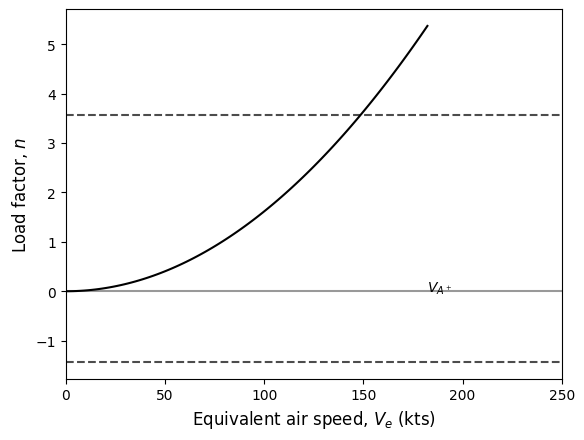

In [34]:
import matplotlib.pyplot as plt

fs = 12

fig, ax = plt.subplots()

ax.axhline(y=nplus, linestyle="--", color="k", alpha=0.7)
ax.axhline(y=nminus, linestyle="--", color="k", alpha=0.7)
ax.axhline(y=0, linestyle="-", color="k", alpha=0.4)

ax.plot(compute_Ve(V_pos_stall_line)/1.688,pos_stall_line, "k")

# Annotations
ax.annotate("$V_{A^+}$", (compute_Ve(Va_pos)/1.688,0))

# Asthetics
ax.set_xlim(left=0, right=250)
ax.set_xlabel("Equivalent air speed, $V_e$ (kts)", fontsize=fs)
ax.set_ylabel("Load factor, $n$", fontsize=fs)